# This notebook generates figure09, which show that thermal resistance is the controlling variable for Ic suppression during irradiation.

In [18]:
%pylab notebook

from scipy.optimize import curve_fit

import sys, os, importlib, warnings, pandas as pd, seaborn as sns
warnings.filterwarnings("ignore")

sys.path.append('lib/')
import hts_fitting as hts, default_figure_style as dfs, hts_fitfunctions as ff
for lib in [hts, dfs, ff]:
    importlib.reload(lib)


########## Load data ############
#################################

cols = [0, 1, 9, 12, 13, 41, 45, 52, 55, 56, 59]
names = ['tapeid', 'anneal', 'ibeam', 'energy', 'power', 'tTAR_OFF', 'tTAR_ON', 'tREBCO', 'suppression', 'suppressionError', 'outlier' ]
df = pd.read_excel(dfs.master, sheet_name='data', usecols=cols, names=names, skiprows=1)


########## Filter data ##########
#################################
cut = df.tTAR_OFF < 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1

data = df[cut]

print('\n\nTotal datapoints', data.energy.count())
for tapeid in data.tapeid.unique():
    print('\nDatapoints for', tapeid, data[data.tapeid==tapeid].energy.count())

for energy in data.energy.unique():
    print('\nDatapoints for', energy, data[data.energy==energy].energy.count())
df.columns

outputDirectory = '../figures/raw/'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Total datapoints 656

Datapoints for f33 68

Datapoints for f20 11

Datapoints for f34 9

Datapoints for f29 302

Datapoints for f23 2

Datapoints for f28 58

Datapoints for f37 206

Datapoints for 150 167

Datapoints for 800 136

Datapoints for 2400 129

Datapoints for 1200 224


## Figure 09 description

This figure compares all tapes by renormalizing the values to the slope of ffj28, and renormalizing the power to 36 mW (which is where most of the data was acquired). The distribution is then processed using the JMP statistical tool (not shown).

<IPython.core.display.Javascript object>


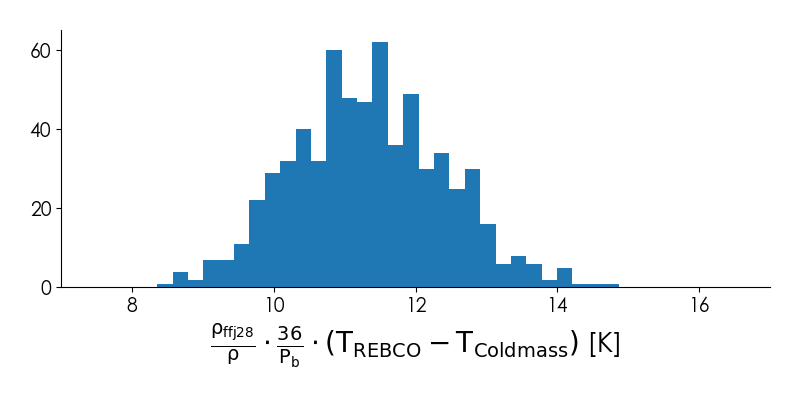

In [19]:
# Find the thermal resistance of ffj28

d = data[(data.tapeid == 'f28') & (data.tREBCO-data.tTAR_ON > 0)]
popt, _ = curve_fit(ff.affine, d.power, d.tREBCO-d.tTAR_ON)
rho0 = popt[0]

pp, gg, ii, ee, aa, tt, yn150keV = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

datasets = ['f20-1', 'f28-1', 'f29-1', 'f29-2', 'f33-1', 'f34-1', 'f37-1', 'f37-2']

for dataset in datasets:
    tape = dataset.split('-')[0]
    cut = (data.tapeid == tape)
    if int(dataset.split('-')[1]) > 1:
        cut &= (data.anneal > 1)
    else:
        cut &= (data.anneal == 1)
    cut &= (data.tREBCO-data.tTAR_ON > 0) # Some corrections fail and produce tREBCO = 0, which leads to a negative dT.
    d = data[cut]
    
    popt, _ = curve_fit(ff.affine, d.power, d.tREBCO-d.tTAR_ON)
    
    gg = np.append(gg, (rho0/popt[0])*(36./d.power)*(d.tREBCO-d.tTAR_ON)) # Normalized suppression
    pp = np.append(pp, d.power)   # Beam power
    ee = np.append(ee, d.energy)  # Beam energy
    ii = np.append(ii, d.index+3) # Index in the Data Master Excel Sheet (+3 due to header)
    aa = np.append(aa, d.anneal)  # Number of times the tape experience room temperature
    tt = np.append(tt, d.tapeid)  # Tapeid
    yn = []
    for e in d.energy:
        if e == 150:
            yn.append(1)
        else:
            yn.append(0)
    yn150keV = np.append(yn150keV, yn)

# Plot the distribution of normalized suppression
fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)
ax.hist(gg, bins=30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel(r'$\mathrm{\frac{\rho_{ffj28}}{\rho}  \cdot \frac{36}{P_b} \cdot \left( T_{REBCO} - T_{Coldmass} \right)}$ [K]', color='k')
ax.set_xlim(7, 17)
fig.tight_layout()
plt.savefig(outputDirectory+'histogram-python.svg', format='svg', transparent=True)

df = pd.DataFrame({'dT': gg, 'power': pp, 'energy': ee, 'tape': tt, 'anneal': aa, 'yn150keV': yn150keV, 'index': ii})
df.to_excel('../data/histograms/jmpdata.xlsx'.format(df, index=False))